# Validation Study
### TDT pipeline
Peter Yazdi

Welcome to Testing Script V1. This is intended for reviewing outputs as of V1 code in DEBUG mode. Note need to run all script in order for it to work. Please contact @pyazdi@bccrc.ca for any questions

This script is intended for preprocess outputs

In [1]:
#imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib
import os
from json_minify import json_minify
import json
import numpy as np
from scipy.ndimage import zoom
import torch

# SETUP - USER ADJUST FOR TEST FILE

In [2]:
current_file = '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/' # Path of current file
config_path = os.path.join(current_file, 'inputs/config.json') # Path of configuration file

with open(config_path, encoding="utf-8") as f:
    config = json.loads(json_minify(f.read())) # Load configuration file
    
output_folder_path = os.path.join(current_file,config["output_folder"]["title"]) # Path of output folder
print("Output folder path:", output_folder_path)


roi_list = list(config['spect_preprocessing']['roi_subset'])
if 'body' not in roi_list:
    roi_list.append('body')
print("ROI list:", roi_list)

def adjust_roi(roi_subset):
        has_left = "kidney_left" in roi_subset
        has_right = "kidney_right" in roi_subset

        if has_left and not has_right:
            raise ValueError("PBPK requires both kidneys (missing kidney_right).")
        if has_right and not has_left:
            raise ValueError("PBPK requires both kidneys (missing kidney_left).")

        if has_left and has_right:
            new_subset = [r for r in roi_subset if r not in ("kidney_left", "kidney_right")]
            if "kidney" not in new_subset:
                new_subset.append("kidney")
            return new_subset

        return list(roi_subset)
    

roi_list = adjust_roi(roi_list)
print("Adjusted ROI list:", roi_list)

Output folder path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick
ROI list: ['kidney', 'liver', 'prostate', 'spleen', 'heart', 'salivary_glands', 'body']
Adjusted ROI list: ['kidney', 'liver', 'prostate', 'spleen', 'heart', 'salivary_glands', 'body']


# INPUT CT

Loading input CT from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/inputs/CT
Input CT path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/inputs/CT


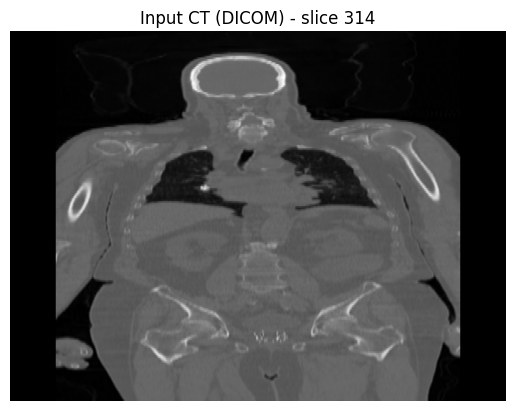

In [3]:
#input CT 
input_ct_path = config["ct_input"]["path1"]
print("Loading input CT from:", input_ct_path)

print("Input CT path:", input_ct_path)
if os.path.isdir(input_ct_path):
    reader = sitk.ImageSeriesReader()
    series_id = reader.GetGDCMSeriesIDs(input_ct_path)[0]
    file_names = reader.GetGDCMSeriesFileNames(input_ct_path, series_id)
    reader.SetFileNames(file_names)
    img = reader.Execute()
    arr_zyx = sitk.GetArrayFromImage(img)          # (z, y, x)
    vol = arr_zyx       # -> (x, y, z)
    title = "Input CT (DICOM)"
    


else:
    # NIfTI file (nibabel)
    vol = nib.load(input_ct_path).get_fdata()
    if vol.ndim == 4:
        vol = vol[..., 0]
    title = "Input CT (NIfTI)"

# Plot slice
axis=1
cmap="gray"
slice_idx = vol.shape[axis] // 2
sl = np.take(vol, slice_idx, axis=axis)

plt.imshow(sl[::-1], cmap=cmap, aspect = 'auto')
plt.title(f"{title} - slice {slice_idx}")
plt.axis("off")
plt.show()

# SPECT PREPROCESSING OUTPUTS

### Setup

In [4]:
# spect preprocessing outputs path
spect_preprocessing_dir_path = os.path.join(output_folder_path, config['subdir_names']['spect_preprocessing'])
print("Loading SPECT preprocessing outputs from:", spect_preprocessing_dir_path)
spect_preprocessing_prefix = config['spect_preprocessing']['name']

#files

# confirm run_totseg outputs (nii files)
ct_nii_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_ct.nii.gz')
roi_seg_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_total_ml.nii.gz')
body_seg_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_body_ml.nii.gz')
head_seg_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_head_glands_cavities_ml.nii.gz')


print("CT NIfTI path:", ct_nii_path)
print("ROI Segmentation path:", roi_seg_path)
print("Body Segmentation path:", body_seg_path)

# check bin outputs
atn_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_atn_av.bin')
roi_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_roi_seg.bin')
body_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_body_seg.bin')
roi_body_seg_bin_path = os.path.join(spect_preprocessing_dir_path, f'{spect_preprocessing_prefix}_roi_body_seg.bin')
print("ATN binary path:", atn_bin_path)
print("ROI Segmentation path:", roi_seg_bin_path)
print("Body Segmentation path:", body_seg_bin_path)
print("ROI and Body Segmentation path:", roi_body_seg_bin_path)



Loading SPECT preprocessing outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/spect_preprocessing_outputs
CT NIfTI path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/spect_preprocessing_outputs/spect_preprocessing_ct.nii.gz
ROI Segmentation path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/spect_preprocessing_outputs/spect_preprocessing_total_ml.nii.gz
Body Segmentation path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/spect_preprocessing_outputs/spect_preprocessing_body_ml.nii.gz
ATN binary path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/spect_preprocessing_outputs/spect_preprocessing_atn_av.bin
ROI Segmentation path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/spect_preprocessing_outputs/spect_preprocessing_roi_seg.bin
Body Segmentation path: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/spect_prep

### Total Seg Outputs

#### Load nii.gz files

In [5]:
def print_nii_info(name, img):
    """
    Print NIfTI image information."""
    hdr = img.header
    print(f"\n--- {name} ---")
    print(f"shape: {img.shape}, dtype: {hdr.get_data_dtype()}")
    print("voxel spacing mm (zooms):", hdr.get_zooms())
    print("affine:\n", img.affine)
    
#load nii files
ct_nii = nib.load(ct_nii_path)
roi_seg = nib.load(roi_seg_path)
body_seg = nib.load(body_seg_path)

# --- Print NIfTI info ---
print_nii_info("CT", ct_nii)
print_nii_info("ROI Seg", roi_seg)
print_nii_info("Body Seg", body_seg)

# --- Arr spacing checks ---
ct_hdr = ct_nii.header
roi_hdr = roi_seg.header
body_hdr = body_seg.header

ct_zooms = ct_hdr.get_zooms()
roi_zooms = roi_hdr.get_zooms()
body_zooms = body_hdr.get_zooms()

print("\n--- Voxel Spacing Comparison (mm) ---")
print(f"CT voxel spacing (mm): {ct_zooms}")
print(f"ROI Seg voxel spacing (mm): {roi_zooms}")
print(f"Body Seg voxel spacing (mm): {body_zooms}")


--- CT ---
shape: (629, 629, 224), dtype: float64
voxel spacing mm (zooms): (np.float32(0.9758117), np.float32(0.97581184), np.float32(4.987864))
affine:
 [[-9.75807130e-01  2.99624959e-03  2.28539706e-04  3.05914795e+02]
 [ 2.99574574e-03  9.75770175e-01 -4.34496403e-02 -1.42318649e+02]
 [ 7.08361549e-05  8.50018952e-03  4.98767471e+00  8.69822021e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

--- ROI Seg ---
shape: (629, 629, 224), dtype: uint8
voxel spacing mm (zooms): (np.float32(0.9758117), np.float32(0.97581184), np.float32(4.987864))
affine:
 [[-9.75807130e-01  2.99624959e-03  2.28539706e-04  3.05914795e+02]
 [ 2.99574574e-03  9.75770175e-01 -4.34496403e-02 -1.42318649e+02]
 [ 7.08361549e-05  8.50018952e-03  4.98767471e+00  8.69822021e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

--- Body Seg ---
shape: (629, 629, 224), dtype: uint8
voxel spacing mm (zooms): (np.float32(0.9758117), np.float32(0.97581184), np.float32(4.98786

#### Plot nii.gz files

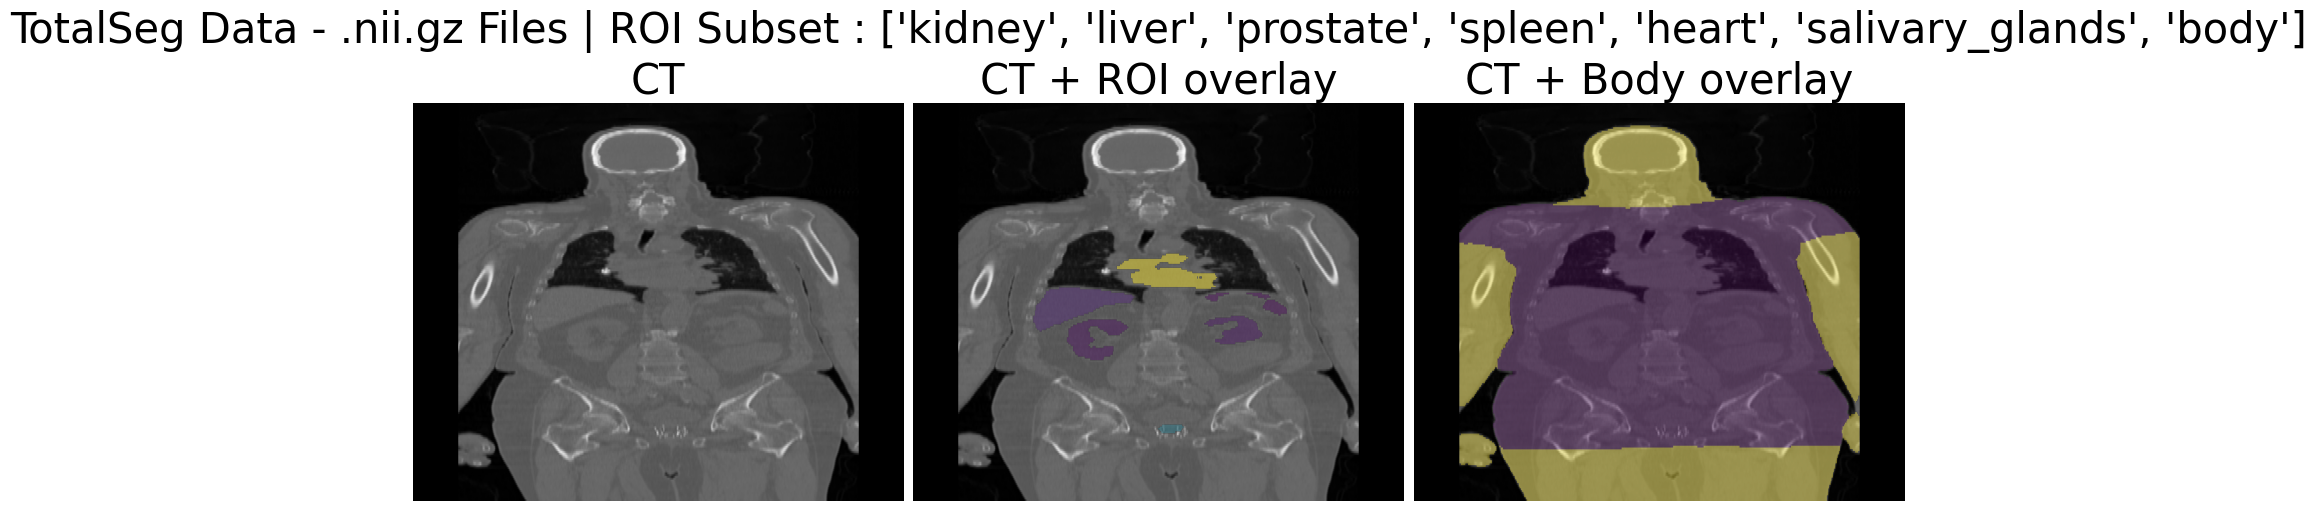

In [6]:
# ------- PLOT SLICES WITH OVERLAYS -------
# data arrays
ct_data   = np.array(ct_nii.get_fdata().transpose((2, 1, 0)), dtype=np.float32)
roi_data  = np.array(roi_seg.get_fdata().transpose((2, 1, 0)), dtype=np.float32)
body_data = np.array(body_seg.get_fdata().transpose((2, 1, 0)), dtype=np.float32)

# select middle slice index in y-direction
slice_index = ct_data.shape[1] // 2

ct_sl   = ct_data[:, slice_index, :]
roi_sl  = roi_data[:, slice_index, :]
body_sl = body_data[:, slice_index, :]

ncols = 3
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)

# 1) CT only
ax[0].imshow(ct_sl[::-1], cmap="gray",aspect='auto')
ax[0].set_title("CT",fontsize=30)
ax[0].axis("off")

# 2) CT + ROI overlay (mask zeros so background is transparent)
ax[1].imshow(ct_sl[::-1], cmap="gray",aspect='auto')
roi_masked = np.ma.masked_where(roi_sl == 0, roi_sl)
im1 = ax[1].imshow(roi_masked[::-1], alpha=0.45,aspect='auto')  
ax[1].set_title("CT + ROI overlay",fontsize=30)
ax[1].axis("off")

# 3) CT + Body overlay
ax[2].imshow(ct_sl[::-1], cmap="gray",aspect='auto')
body_masked = np.ma.masked_where(body_sl == 0, body_sl)
im2 = ax[2].imshow(body_masked[::-1], alpha=0.35,aspect='auto')
ax[2].set_title("CT + Body overlay",fontsize=30)
ax[2].axis("off")

fig.suptitle(f"TotalSeg Data - .nii.gz Files | ROI Subset : {roi_list}", fontsize=30)
plt.show()

### Preprocess Data Outputs 

#### Resize to scale factor

In [7]:
# --- Resize ROI array and compute new pixel spacing ---
# should be same for all
shape = roi_data.shape
print("Original ROI shape:", roi_data.shape)
print("Array Type:", roi_data.dtype) 

resize = config['spect_preprocessing']['xy_dim']
scale = resize / roi_data.shape[1]
roi_data_new = zoom(roi_data, (scale, scale, scale), order=0)
shape_new = roi_data_new.shape
print("Resized ROI shape:", shape_new)

zooms_mm = np.array(ct_nii.header.get_zooms()[:3], dtype=float) / scale
zooms_mm = zooms_mm[[2, 1, 0]]
arr_px_spacing_cm = tuple(float(x) * 0.1 for x in zooms_mm)
print(f"Array pixel spacing resized (cm): {arr_px_spacing_cm}")

Original ROI shape: (224, 629, 629)
Array Type: float32
Resized ROI shape: (91, 256, 256)
Array pixel spacing resized (cm): (1.2255337761715055, 0.239760018279776, 0.239759988989681)


#### Load and Plot .bin files

ROI unique values: [0. 1. 2. 3. 4. 5. 6. 7.]
Body unique values: [0. 1.]
ROI+Body unique values: [0. 1. 2. 3. 4. 5. 6. 7.]


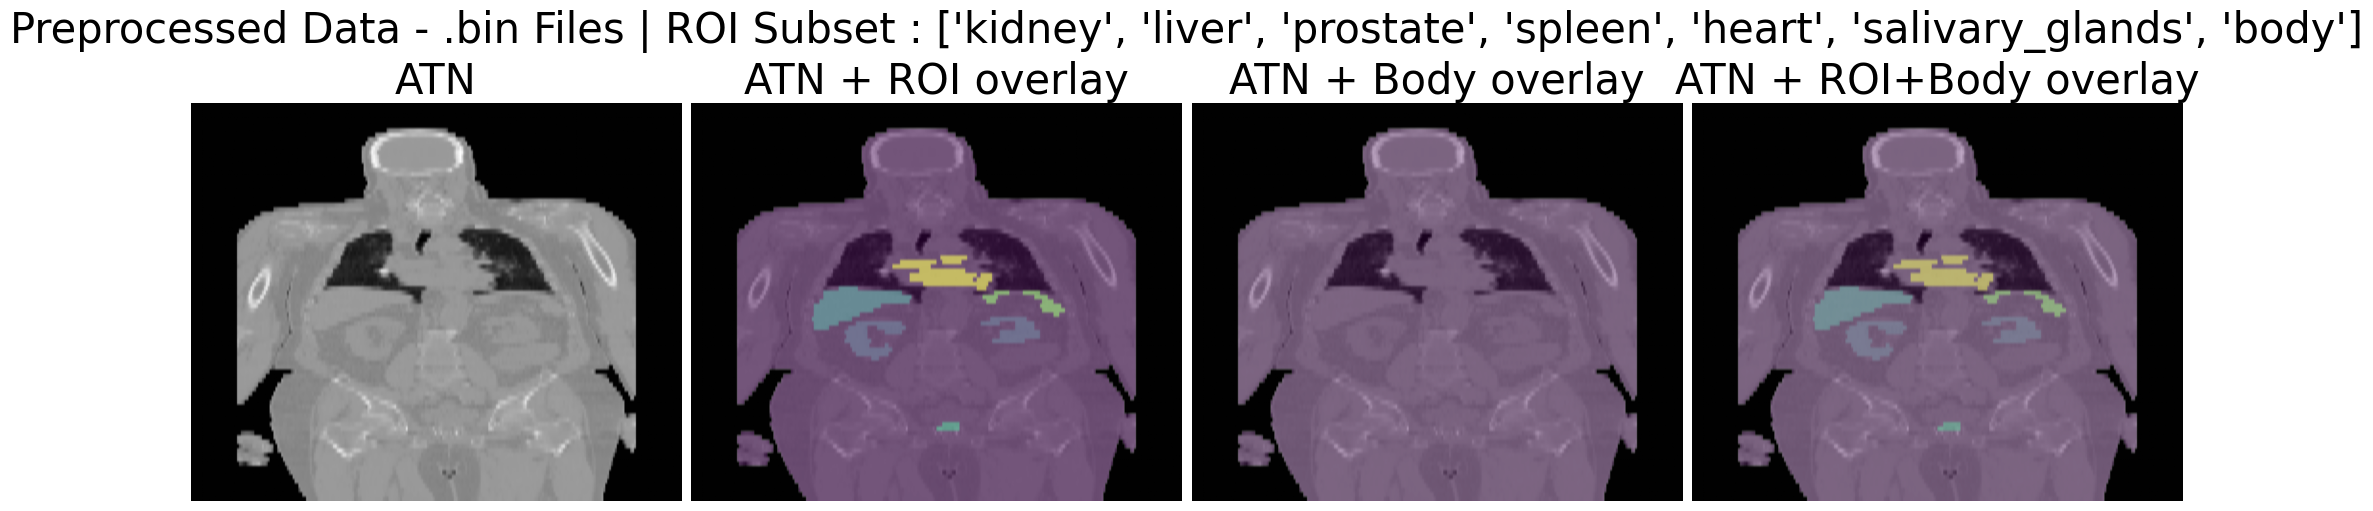

In [8]:
# ------- BIN FILES PLOTS -------
# data arrays
atn_data = np.fromfile(atn_bin_path, dtype=np.float32).reshape(shape_new)
roi_data = np.fromfile(roi_seg_bin_path, dtype=np.float32).reshape(shape_new)
body_data = np.fromfile(body_seg_bin_path, dtype=np.float32).reshape(shape_new)
roi_body_data = np.fromfile(roi_body_seg_bin_path, dtype=np.float32).reshape(shape_new)

print(f"ROI unique values: {np.unique(roi_data)}")
print(f"Body unique values: {np.unique(body_data)}")
print(f"ROI+Body unique values: {np.unique(roi_body_data)}")

slice_index = atn_data.shape[1] // 2

atn_sl   = atn_data[:, slice_index, :]
roi_sl  = roi_data[:, slice_index, :]
body_sl = body_data[:, slice_index, :]
roi_body_sl = roi_body_data[:, slice_index, :]

ncols = 4
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)


# 1) ATN only
ax[0].imshow(atn_sl[::-1], cmap="gray", aspect='auto')
ax[0].set_title("ATN",fontsize=30)
ax[0].axis("off")

# 2) ATN + ROI overlay (mask zeros so background is transparent)
ax[1].imshow(atn_sl[::-1], cmap="gray", aspect='auto')
roi_masked = np.ma.masked_where(roi_sl == 0, roi_sl)
im1 = ax[1].imshow(roi_masked[::-1], alpha=0.45, aspect='auto')
ax[1].set_title("ATN + ROI overlay",fontsize=30)
ax[1].axis("off")

# 3) ATN + Body overlay
ax[2].imshow(atn_sl[::-1], cmap="gray", aspect='auto')
body_masked = np.ma.masked_where(body_sl == 0, body_sl)
im2 = ax[2].imshow(body_masked[::-1], alpha=0.35, aspect='auto')
ax[2].set_title("ATN + Body overlay",fontsize=30)
ax[2].axis("off")

# 4) ATN + ROI+Body overlay
ax[3].imshow(atn_sl[::-1], cmap="gray", aspect='auto')
roi_body_masked = np.ma.masked_where(roi_body_sl == 0, roi_body_sl)
im3 = ax[3].imshow(roi_body_masked[::-1], alpha=0.35, aspect='auto')
ax[3].set_title("ATN + ROI+Body overlay",fontsize=30)
ax[3].axis("off")   


fig.suptitle(f"Preprocessed Data - .bin Files | ROI Subset : {roi_list}", fontsize=30)
plt.show()


# PBPK OUTPUTS

### Setup

In [9]:
pbpk_dir_path = os.path.join(output_folder_path, config['subdir_names']['pbpk'])
print("Loading PBPK outputs from:", pbpk_dir_path)
pbpk_prefix = config['pbpk']['name']

# check PBPK outputs TAC from PyCNO
frames_start_times = config['pbpk']['FrameStartTimes'] # all frames start times [min]

# grab shape details: 
shape  = shape_new
print("Shape of arrays:", shape) # all should be the same shape

# grab vois for PyCNO
vois = [v.lower() for v in config["pbpk"]["VOIs"]]
print("PBPK VOIs:", vois)

# grab rois from totalseg
rois = roi_list.copy()
print("Totalseg ROIs:", rois)

Loading PBPK outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/pbpk_outputs
Shape of arrays: (91, 256, 256)
PBPK VOIs: ['tumor1', 'tumor2', 'kidney', 'heart', 'sg', 'bone', 'tumorrest', 'spleen', 'liver', 'prostate', 'gi', 'rest', 'skin', 'muscle', 'brain', 'redmarrow', 'lungs', 'adipose']
Totalseg ROIs: ['kidney', 'liver', 'prostate', 'spleen', 'heart', 'salivary_glands', 'body']


#### TAC Produced Via PyCNO (Activity per ROI per Frame)

ROI: kidney
Frame Time : 4 hrs | Activity: 170.0826416015625 MBq
ROI: liver
Frame Time : 4 hrs | Activity: 422.2039794921875 MBq
ROI: prostate
Frame Time : 4 hrs | Activity: 12.014142036437988 MBq
ROI: spleen
Frame Time : 4 hrs | Activity: 10.300233840942383 MBq
ROI: heart
Frame Time : 4 hrs | Activity: 22.241823196411133 MBq
ROI: salivary_glands
Frame Time : 4 hrs | Activity: 15.562541961669922 MBq
ROI: body
Frame Time : 4 hrs | Activity: 1201.7181396484375 MBq


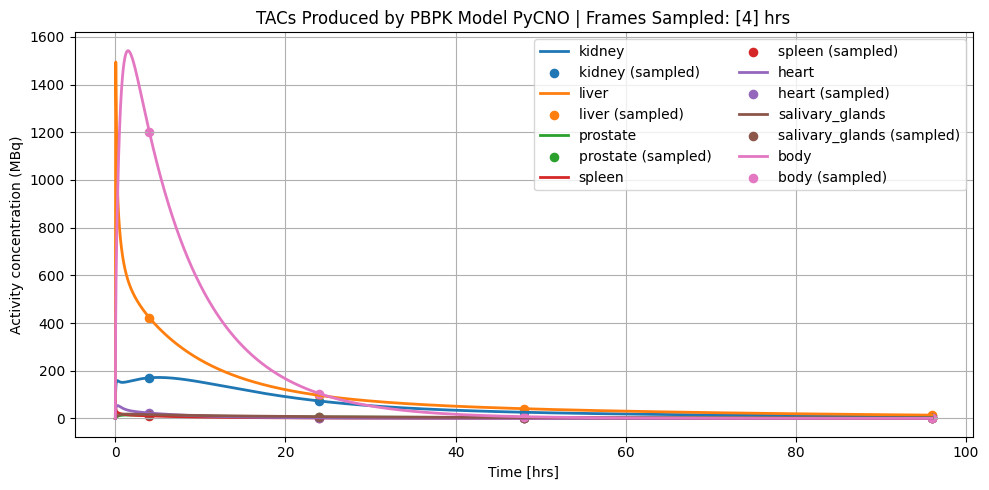

In [12]:
# ------- LOAD TAC BIN FILES-------
def load_tac_bins(roi, base_path=pbpk_dir_path, pbpk_prefix=pbpk_prefix):
    roi = roi.lower()
    t  = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_TAC_time.bin"), dtype=np.float32)
    act  = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_TAC_values.bin"), dtype=np.float32)
    t_s = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_sample_times.bin"), dtype=np.float32)
    act_s = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_sample_values.bin"), dtype=np.float32)
    return t, act, t_s, act_s

# --- One plot for all ROIs ---
plt.figure(figsize=(10, 5))

sampled_activity = {}

for roi in rois:
    roi = roi.lower()
    t_file = os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{roi}_TAC_time.bin")
    if not os.path.exists(t_file):
        print(f"Skipping '{roi}' (missing files).")
        continue

    t, act, t_s, act_s = load_tac_bins(roi)

    plt.plot(t/60, act, linewidth=2, label=f"{roi}")
    plt.scatter(t_s/60, act_s, s=35, label=f"{roi} (sampled)")
    sampled_activity[roi] = act_s.astype(float).tolist()
for roi in sampled_activity:
    print(f"ROI: {roi}")
    for indx, fr in enumerate(frames_start_times):
        print(f"Frame Time : {int(fr/60)} hrs | Activity: {sampled_activity[roi][indx]} MBq")

plt.title(f"TACs Produced by PBPK Model PyCNO | Frames Sampled: {[int(f/60) for f in frames_start_times]} hrs")
plt.xlabel("Time [hrs]")
plt.ylabel("Activity concentration (MBq)")
plt.grid()
plt.legend(ncol=2)  # makes legend less tall if many ROIs
plt.tight_layout()
plt.show()

#### Volumes of each ROI - Assume Activity Map uniform activty across organ

ROI List: ['kidney', 'liver', 'prostate', 'spleen', 'heart', 'salivary_glands', 'body']
Unique values in ROI+Body data: [0 1 2 3 4 5 6 7]
Class map: {'body': 1, 'kidney': 2, 'liver': 3, 'prostate': 4, 'spleen': 5, 'heart': 6, 'salivary_glands': 7}


Calculating volumes for each ROI:
-----


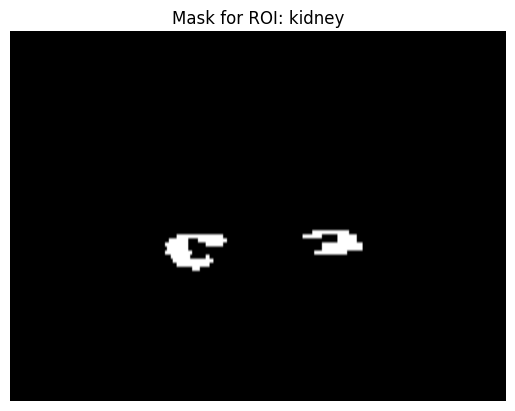

Number of voxels in kidney: 8562
Voxel volume (cm^3): 0.0704496367432225
Volume of kidney: 603.19 cm^3
-----
-----


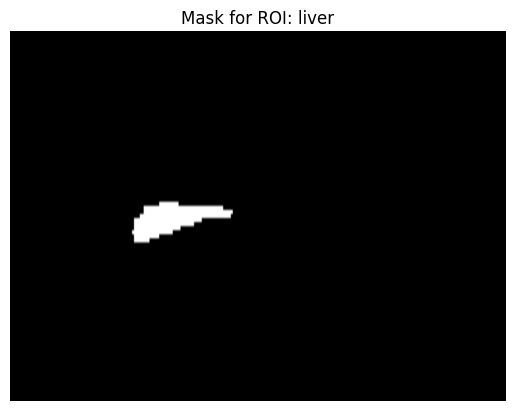

Number of voxels in liver: 26123
Voxel volume (cm^3): 0.0704496367432225
Volume of liver: 1840.36 cm^3
-----
-----


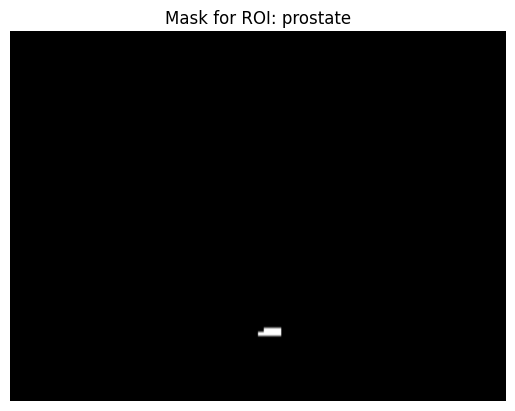

Number of voxels in prostate: 235
Voxel volume (cm^3): 0.0704496367432225
Volume of prostate: 16.56 cm^3
-----
-----


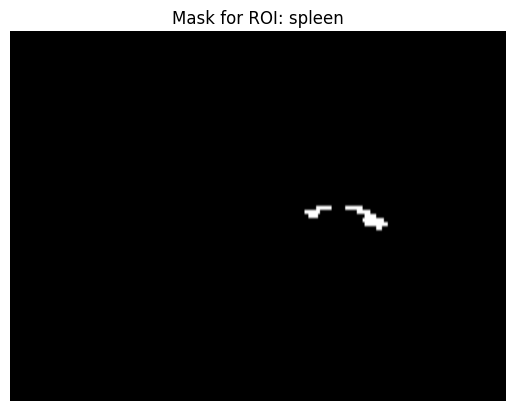

Number of voxels in spleen: 4177
Voxel volume (cm^3): 0.0704496367432225
Volume of spleen: 294.27 cm^3
-----
-----


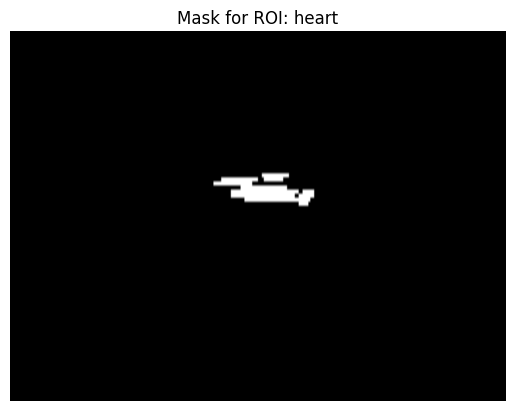

Number of voxels in heart: 10581
Voxel volume (cm^3): 0.0704496367432225
Volume of heart: 745.43 cm^3
-----
-----


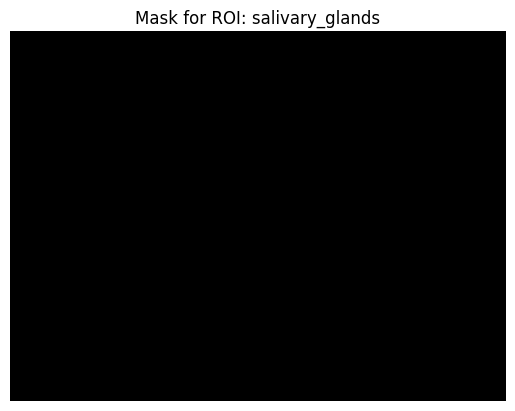

Number of voxels in salivary_glands: 807
Voxel volume (cm^3): 0.0704496367432225
Volume of salivary_glands: 56.85 cm^3
-----
-----


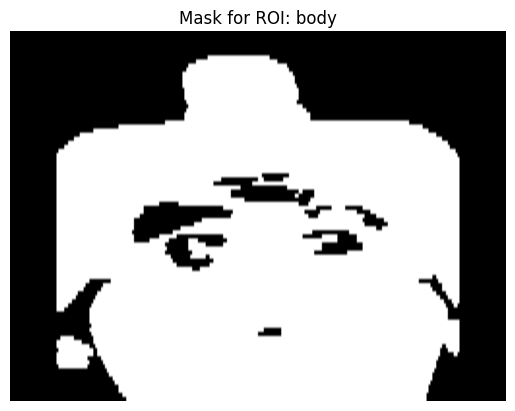

Number of voxels in body: 1182915
Voxel volume (cm^3): 0.0704496367432225
Volume of body: 83335.93 cm^3
-----
Calculated Volumes (cm^3): {'kidney': 603.189789795471, 'liver': 1840.3558606432011, 'prostate': 16.555664634657287, 'spleen': 294.26813267644036, 'heart': 745.4276063800372, 'salivary_glands': 56.85285685178055, 'body': 83335.93204810904}


In [13]:
# find volumes of each ROI region :
roi_list = roi_list.copy() 
print(f"ROI List: {roi_list}")
# to avoid modifying original data
roi_body_data = np.fromfile(os.path.join(spect_preprocessing_dir_path, 
                                        f"{spect_preprocessing_prefix}_roi_body_seg.bin"),
                                        np.float32).reshape(shape).astype(int) 
unique_values = np.unique(roi_body_data.astype(int))
print("Unique values in ROI+Body data:", unique_values)

def _build_class_map(arr, unique_values, classes):
        class_map = {}
        for value in unique_values:
            if value == 0:
                continue
            name = classes.get(str(value))
            if name is not None:
                class_map[name] = int(value)
        return class_map
    
# classes
TDT_Pipeline:{ 
    "0": "background",
    "1": "body",
    "2": "kidney",
    "3": "liver",
    "4": "prostate",
    "5": "spleen",
    "6": "heart",
    "7": "salivary_glands"
}

classes = {
    "0": "background",
    "1": "body",
    "2": "kidney",
    "3": "liver",
    "4": "prostate",
    "5": "spleen",
    "6": "heart",
    "7": "salivary_glands"
}
class_map = _build_class_map(roi_body_data, unique_values, classes)
print("Class map:", class_map)
print("\n")

volume_roi = {}
mask_roi = {}
print("Calculating volumes for each ROI:")
for roi in roi_list:
    print("-----")
    mask = (roi_body_data == class_map.get(roi))
    plt.imshow(mask[:, mask.shape[1]//2, :][::-1], cmap="gray", aspect='auto')
    plt.title(f"Mask for ROI: {roi}")
    plt.axis("off")
    plt.show()
    
    volume_voxels = np.sum(mask) # count voxels in mask
    print(f"Number of voxels in {roi}: {volume_voxels}")
    voxel_volume_cm3 = arr_px_spacing_cm[0] * arr_px_spacing_cm[1] * arr_px_spacing_cm[2]  # assuming same spacing for all roi
    print(f"Voxel volume (cm^3): {voxel_volume_cm3}")
    volume_cm3 = volume_voxels * voxel_volume_cm3
    print(f"Volume of {roi}: {volume_cm3:.2f} cm^3")
    print("-----")
    volume_roi[str(roi)] = float(volume_cm3)
    mask_roi[str(roi)] = mask.astype(np.uint8)
    

print("Calculated Volumes (cm^3):", volume_roi)


### Check PBPK Activity Maps Created (.bin files)

#### Frame-based PBPK Actitvty Map (.bin) Plots

Using shape for PBPK frames: (91, 256, 256)


TypeError: Invalid shape (91,) for image data

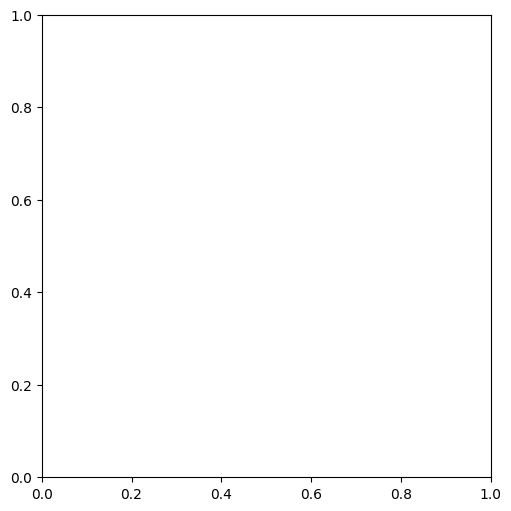

In [ ]:
titles = []
slices = []
global_min = np.inf
global_max = -np.inf
shape  = shape_new
print("Using shape for PBPK frames:", shape)

for frame in frames_start_times:
    pbpk_frame_arr = np.fromfile(os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{frame}_act_av.bin"), dtype=np.float32).reshape(shape)
    
    slice_index = pbpk_frame_arr.shape[1] // 2  # same slice for all frames
    sl = pbpk_frame_arr[:, slice_index, :]
    
    # update global min/max (nan-safe)
    sl_min = np.nanmin(sl)
    sl_max = np.nanmax(sl)
    if sl_min < global_min: global_min = sl_min
    if sl_max > global_max: global_max = sl_max

    slices.append(sl)
    titles.append(f"t={int(frame/60)} hrs | slice {slice_index}")
    
# Common choice for activity maps:
vmax = float(global_max) if np.isfinite(global_max) else 1.0

ncols = len(slices)
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

im = None
for i, ax in enumerate(axes):
    if i < len(slices):
        im = ax.imshow(np.max(slices[::-1],axis=1), cmap="turbo", vmin=vmin, vmax=vmax, aspect='auto')
        ax.set_title(titles[i], fontsize=20)
        ax.axis("off")
    else:
        ax.axis("off")

# one shared colorbar for the whole figure
fig.colorbar(im, ax=axes.tolist(), label="Activity (MBq/mL)")
fig.suptitle(f"PBPK Activity - Frame .bin Files", fontsize=30)
plt.show()

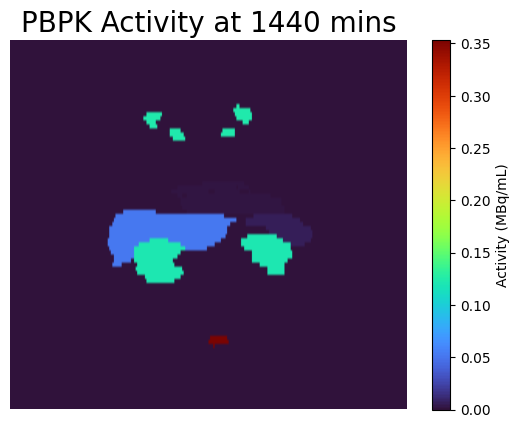

In [30]:
path = "/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_quick/pbpk_outputs/pbpk_1440_act_av.bin"

arr= np.fromfile(path, dtype=np.float32).reshape(shape)
plt.imshow(np.max(arr[::-1],axis=1), cmap="turbo", aspect='auto')
plt.title("PBPK Activity at 1440 mins", fontsize=20)
plt.colorbar(label="Activity (MBq/mL)")
plt.axis("off")
plt.show()

#### Ogran-based PBPK Actitvty Map (.bin) - Check bin made correctly

Using shape for PBPK frames: (91, 256, 256)


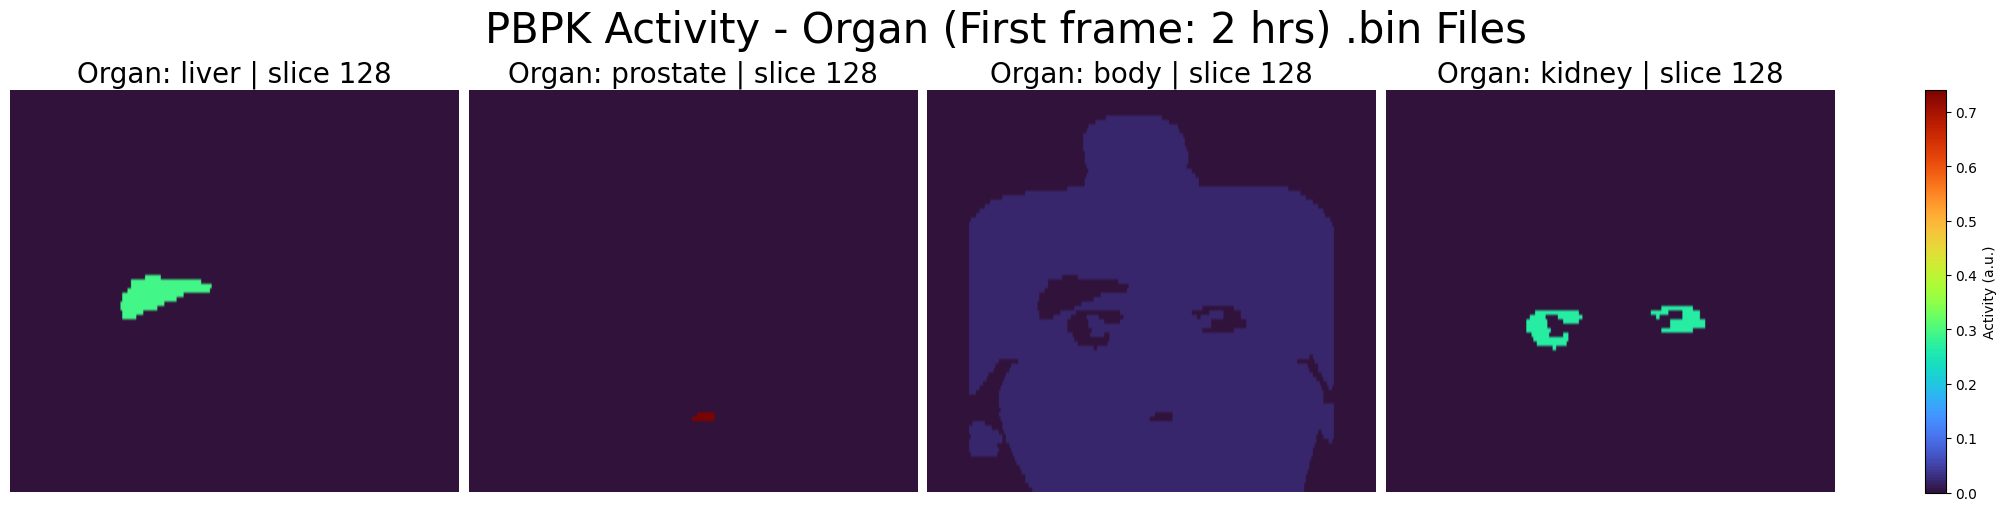

In [ ]:
slices = []
titles = []
global_min = np.inf
global_max = -np.inf
shape = shape_new
print("Using shape for PBPK frames:", shape)
for organ in roi_list:
    pbpk_frame_arr = np.fromfile(os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{organ}_act_av.bin"), dtype=np.float32).reshape(shape)
    
    slice_index = pbpk_frame_arr.shape[1] // 2  # same slice for all frames
    sl = pbpk_frame_arr[:, slice_index, :]
    
    # update global min/max (nan-safe)
    sl_min = np.nanmin(sl)
    sl_max = np.nanmax(sl)
    if sl_min < global_min: global_min = sl_min
    if sl_max > global_max: global_max = sl_max

    slices.append(sl)
    titles.append(f"Organ: {organ} | slice {slice_index}")
    
# Common choice for activity maps:
vmin = 0.0 if np.isfinite(global_min) else 0.0
vmax = float(global_max) if np.isfinite(global_max) else 1.0

ncols = len(slices)
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

im = None
for i, ax in enumerate(axes):
    if i < len(slices):
        im = ax.imshow(slices[i][::-1], cmap="turbo", vmin=vmin, vmax=vmax, aspect='auto')
        ax.set_title(titles[i], fontsize=20)
        ax.axis("off")
    else:
        ax.axis("off")

# one shared colorbar for the whole figure
fig.colorbar(im, ax=axes.tolist(), label="Activity (a.u.)")
fig.suptitle(f"PBPK Activity - Organ (First frame: {int(frames_start_times[0]/60)} hrs) .bin Files", fontsize=30)
plt.show()

### Confirming Correct Activity values in Activity Map (.bin)

#### Exepcted Activity via TAC + Volumes

In [ ]:
frames_start_times = config['pbpk']['FrameStartTimes'] # all frames start times [min]
TAC_sampled_values = sampled_activity # units of MBq, correpond to each frame
print("TAC Sampled Values:", TAC_sampled_values)
print("TAC Frame Start Times (hrs):", [int(f/60) for f in frames_start_times])

# map roi activity to aquire roi : Mbq/ml value
# assuming each roi has same activity uniformaly distributed
# assuming 1 ml = 1 cm^3
masks = mask_roi
volumes = volume_roi
roi_activity_Mbq_ml_expected = {}
for roi in roi_list:
    roi = roi.lower()
    print(f"--- ROI: {roi} ---")
    volume_cm3 = volumes.get(str(roi))  # in cm^3
    activity_values = TAC_sampled_values.get(roi)  # in MBq
    activity_Mbq_per_ml = []
    for activity in activity_values:
        activity_conc = activity / volume_cm3  # MBq/ml
        activity_Mbq_per_ml.append(activity_conc)
        print(f"Activity: {activity} MBq | Volume: {volume_cm3:.2f} cm^3 | Activity Concentration: {activity_conc:.2f} MBq/ml")
    roi_activity_Mbq_ml_expected[str(roi)] = activity_Mbq_per_ml
print("\n")
print(f"Expected ROI Activty [Mbq/ml]:\n{roi_activity_Mbq_ml_expected}")

TAC Sampled Values: {'liver': [540.249755859375, 96.3432846069336, 40.494293212890625, 22.918167114257812, 3.6800472736358643], 'prostate': [13.458171844482422, 5.849533557891846, 3.262239694595337, 1.9243258237838745, 0.31083351373672485], 'body': [1722.5238037109375, 241.86331176757812, 101.1678466796875, 68.58045196533203, 22.278221130371094], 'kidney': [158.00863647460938, 72.77494812011719, 25.52137565612793, 13.477349281311035, 2.1373674869537354]}
TAC Frame Start Times (hrs): [2, 24, 48, 72, 156]
--- ROI: liver ---
Activity: 540.249755859375 MBq | Volume: 1843.39 cm^3 | Activity Concentration: 0.29 MBq/ml
Activity: 96.3432846069336 MBq | Volume: 1843.39 cm^3 | Activity Concentration: 0.05 MBq/ml
Activity: 40.494293212890625 MBq | Volume: 1843.39 cm^3 | Activity Concentration: 0.02 MBq/ml
Activity: 22.918167114257812 MBq | Volume: 1843.39 cm^3 | Activity Concentration: 0.01 MBq/ml
Activity: 3.6800472736358643 MBq | Volume: 1843.39 cm^3 | Activity Concentration: 0.00 MBq/ml
--- RO

#### Calcualted Activity via .bin files

In [ ]:
# map roi activity to aquire roi : Mbq/ml value
# assuming each roi has same activity uniformaly distributed
# assuming 1 ml = 1 cm^3
masks = mask_roi
shape  = shape_new
print("Using shape for PBPK frames:", shape)
roi_activity_Mbq_ml_calculated = {}

for roi in roi_list:
    # create activity map based on roi masks and activity concentrations
    roi_activites = []
    roi = roi.lower()
    mask = masks.get(str(roi))
    for frame in frames_start_times:
        pbpk_frame_arr = np.fromfile(os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{frame}_act_av.bin"), dtype=np.float32).reshape(shape)
        vals = pbpk_frame_arr[mask.astype(bool)]
        roi_mean = float(vals.mean())
        roi_activites.append(roi_mean)
    roi_activity_Mbq_ml_calculated[str(roi)] = roi_activites

print("\n")
print("Calculated ROI Activty [Mbq/ml]:\n")
for roi in roi_activity_Mbq_ml_calculated:
    print(f"ROI: {roi} | Activities: {[round(act, 4) for act in roi_activity_Mbq_ml_calculated[roi]]} Mbq/ml")


Using shape for PBPK frames: (91, 256, 256)


Calculated ROI Activty [Mbq/ml]:

ROI: liver | Activities: [0.2931, 0.0523, 0.022, 0.0124, 0.002] Mbq/ml
ROI: prostate | Activities: [0.7404, 0.3218, 0.1795, 0.1059, 0.0171] Mbq/ml
ROI: body | Activities: [0.0204, 0.0029, 0.0012, 0.0008, 0.0003] Mbq/ml
ROI: kidney | Activities: [0.2662, 0.1226, 0.043, 0.0227, 0.0036] Mbq/ml


#### Calculated Activity vs Exepcted Activity

In [ ]:
calculated_activty = roi_activity_Mbq_ml_calculated
expected_activty = roi_activity_Mbq_ml_expected
print("Exepcting all difference be = 0")
for roi in roi_list:
    print(f"--- ROI: {roi} ---")
    calc_values = calculated_activty.get(str(roi))
    exp_values = expected_activty.get(str(roi))
    for indx, fr in enumerate(frames_start_times):
        calc_val = calc_values[indx]
        exp_val = exp_values[indx]
        some_val = calc_val/exp_val
        diff = abs(calc_val - exp_val) 
        print(f"Frame Time : {int(fr/60)} hrs | Calculated Activity: {calc_val:.4f} MBq/ml | Expected Activity: {exp_val:.4f} MBq/ml")
        print(f"Difference: {diff:.4f} MBq/ml")
    print("\n")
        


Exepcting all difference be = 0
--- ROI: liver ---
Frame Time : 2 hrs | Calculated Activity: 0.2931 MBq/ml | Expected Activity: 0.2931 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 24 hrs | Calculated Activity: 0.0523 MBq/ml | Expected Activity: 0.0523 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 48 hrs | Calculated Activity: 0.0220 MBq/ml | Expected Activity: 0.0220 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 72 hrs | Calculated Activity: 0.0124 MBq/ml | Expected Activity: 0.0124 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 156 hrs | Calculated Activity: 0.0020 MBq/ml | Expected Activity: 0.0020 MBq/ml
Difference: 0.0000 MBq/ml


--- ROI: prostate ---
Frame Time : 2 hrs | Calculated Activity: 0.7404 MBq/ml | Expected Activity: 0.7404 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 24 hrs | Calculated Activity: 0.3218 MBq/ml | Expected Activity: 0.3218 MBq/ml
Difference: 0.0000 MBq/ml
Frame Time : 48 hrs | Calculated Activity: 0.1795 MBq/ml | Expected Activity: 0.1795 MBq/ml
Differen

# SPECT Simulation

#### SETUP

In [ ]:
spect_sim_dir_path = os.path.join(output_folder_path, config['subdir_names']['spect_simulation'])
print("Loading SPECT simulation outputs from:", spect_sim_dir_path)
spect_sim_prefix = config['spect_simulation']['name']

simind_workdir_path = os.path.join(spect_sim_dir_path, f"simind_work")
print("Loading SIMIND workdir from:", simind_workdir_path)

Loading SPECT simulation outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_time_it_took_1e9/spect_simulation_outputs
Loading SIMIND workdir from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_time_it_took_1e9/spect_simulation_outputs/simind_work


## SIMIND Outputs

#### SIMIND needed parameters + find right shape

In [ ]:
num_projections = config['spect_simulation']['NumProjections']
num_photons = config['spect_simulation']['NumPhotons']
OutputImgSize = config['spect_simulation']['OutputImgSize']
OutputPixelWidth = config['spect_simulation']['OutputPixelWidth']
OutputSliceWidth = config['spect_simulation']['OutputSliceWidth']


print(f"Number of photons: {num_photons:g}")
input_slice_width = arr_px_spacing_cm[0]
output_img_length = int(input_slice_width * shape[0] / OutputSliceWidth)
print(f"Output image length (cm): {output_img_length}")

simind_shape = (num_projections, output_img_length, OutputImgSize)
print(f"SIMIND output shape: {simind_shape}")

Number of photons: 1e+09
Output image length (cm): 446
SIMIND output shape: (64, 446, 256)


#### SIMIND: Frame-Based Projection Plots 

In [ ]:
window = ['w1', 'w2', 'w3']
print("Plotting SIMIND projections for windows:", window)
print("NOTE: This is prior to any reconstruction step or poisson noise addition.")
for f in frames_start_times:
    print(f"--- Frame: {int(f/60)} hrs ---")
    figure, axes = plt.subplots(1, len(window), figsize=(5*len(window), 5), constrained_layout=True)
    for w in window:
        file_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_{int(f)}min_tot_{w}.a00")
        print(f"Loading SIMIND projection from: {file_path}")
        
        photopeak = np.fromfile(file_path, dtype=np.float32)
        projections = (torch.tensor(photopeak.reshape(simind_shape)))
        
        # Plot projection
        projection_num = 0  # first projection
        im = axes[window.index(w)].imshow(projections[projection_num,:,:]) 
        figure.colorbar(im, ax=axes[window.index(w)], label='Counts')
        axes[window.index(w)].set_title(f'Window: {w}')
        axes[window.index(w)].axis('off')
    figure.suptitle(f'SIMIND Photopeak Projections - {int(f/60)} hrs', fontsize=30)
    plt.show()
    
    
    
    

Plotting SIMIND projections for windows: ['w1', 'w2', 'w3']
NOTE: This is prior to any reconstruction step or poisson noise addition.


NameError: name 'frames_start_times' is not defined

## PyTomography Outputs

#### SETUP

In [ ]:
spect_sim_dir_path = os.path.join(output_folder_path, config['subdir_names']['spect_simulation'])
print("Loading SPECT simulation outputs from:", spect_sim_dir_path)
spect_sim_prefix = config['spect_simulation']['name']

Loading SPECT simulation outputs from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs


#### Plot Reconstructed SPECT Image 

Loading Attention Image Used in Reconstruction: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_atn_img.nii


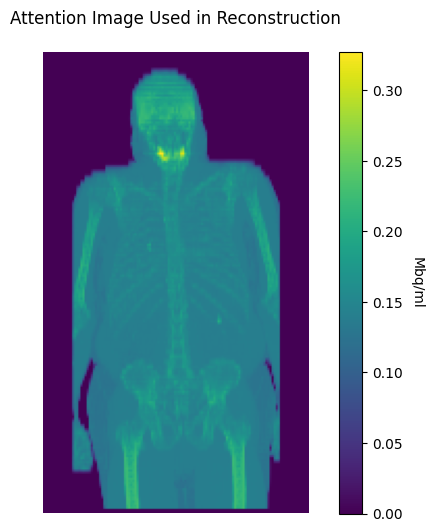

Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_240min.nii
Reconstructed volume shape: (223, 128, 128)
Reconstructed volume spacing (cm): (0.5, 0.5, 0.5)


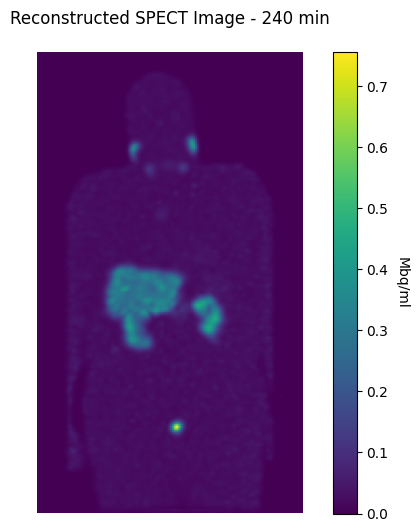

Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_1440min.nii
Reconstructed volume shape: (223, 128, 128)
Reconstructed volume spacing (cm): (0.5, 0.5, 0.5)


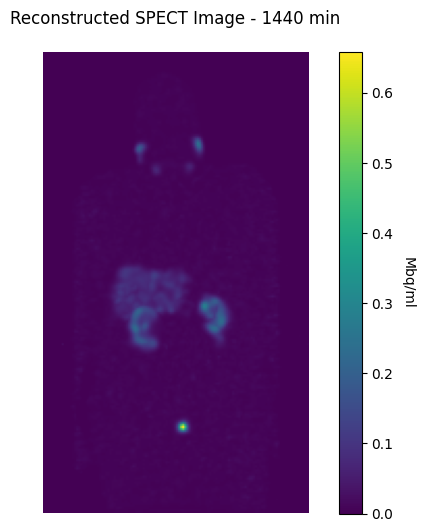

Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_2880min.nii
Reconstructed volume shape: (223, 128, 128)
Reconstructed volume spacing (cm): (0.5, 0.5, 0.5)


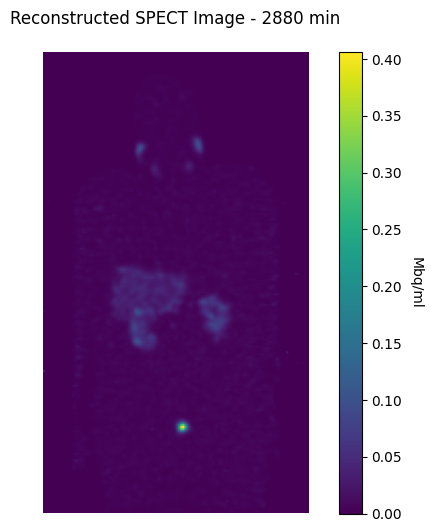

Loading reconstructed volume from: /home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_5760min.nii
Reconstructed volume shape: (223, 128, 128)
Reconstructed volume spacing (cm): (0.5, 0.5, 0.5)


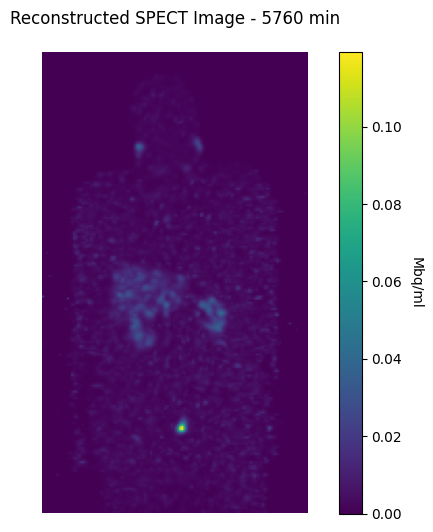

Reconstruction paths:
['/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_240min.nii', '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_1440min.nii', '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_2880min.nii', '/home/jhubadmin/Theranostic-Virtual-Patient-Pipeline/TDT_Output_5e8/spect_simulation_outputs/spect_simulation_5760min.nii']


In [ ]:
# Plot Attention Image Used in Reconstruction
file_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_atn_img.nii")
print(f"Loading Attention Image Used in Reconstruction: {file_path}")
atn = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
plt.figure(figsize=(8, 6))
im = plt.imshow(np.max(atn[::-1], axis=1), cmap='viridis')
plt.title('Attention Image Used in Reconstruction', pad=20)
cbar = plt.colorbar(im)
cbar.set_label('Mbq/ml', rotation=270, labelpad=15)
plt.axis('off')
plt.show()
recon_paths = []

frames_start_times = config['pbpk']['FrameStartTimes'] # all frames start times [min]
for f in frames_start_times:
    file_path = os.path.join(spect_sim_dir_path, f"{spect_sim_prefix}_{int(f)}min.nii")
    print(f"Loading reconstructed volume from: {file_path}")
    recon = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
    shape = recon.shape
    spacing = sitk.ReadImage(file_path).GetSpacing()
    print(f"Reconstructed volume shape: {shape}")
    print(f"Reconstructed volume spacing (cm): {spacing}")
    plt.figure(figsize=(8, 6))
    im = plt.imshow(np.max(recon[::-1], axis=1), cmap='viridis')
    plt.title(f'Reconstructed SPECT Image - {f} min', pad=20)
    cbar = plt.colorbar(im)
    cbar.set_label('Mbq/ml', rotation=270, labelpad=15)
    plt.axis('off')
    plt.show()
    
    recon_paths.append(file_path)

print(f"Reconstruction paths:\n{recon_paths}")

# SPECT Post Processing

## TAC Values via RECON (Compare to PBPK TAC)

### Load RECON images and Segmentated Body + ROI + Parameters needed

In [ ]:
roi_body_seg_arr_old = roi_body_data.copy() # arr [z,y,x] (shape is different then recon)
shape_old = roi_body_seg_arr_old.shape
arr_px_spacing_cm_old = arr_px_spacing_cm # spacing [z,y,x] cm
print(f"Old ROI+Body seg shape: {shape_old} | spacing (cm): {arr_px_spacing_cm_old}")
old_vox_vol = arr_px_spacing_cm_old[0] * arr_px_spacing_cm_old[1] * arr_px_spacing_cm_old[2] # cm^3 = ml
print(f"Old voxel volume: {old_vox_vol} ml")

recon_paths = recon_paths.copy() 
recon_ref = sitk.ReadImage(recon_paths[0])
OutputImgSize = config['spect_simulation']['OutputImgSize'] # cm
OutputPixelWidth = config['spect_simulation']['OutputPixelWidth'] # cm
OutputSliceWidth = config['spect_simulation']['OutputSliceWidth']  # cm 
recon_shape = recon_ref.GetSize()  # (x, y, z)
print(f"Reconstructed Image shape (x,y,z): {recon_shape} | spacing (cm): {(OutputPixelWidth, OutputPixelWidth, OutputSliceWidth)}")
recon_vox_vol = OutputPixelWidth * OutputPixelWidth * OutputSliceWidth  # cm^3 = ml
print(f"Reconstructed voxel volume: {recon_vox_vol} ml")


NameError: name 'roi_body_data' is not defined

### Sample Segementaed data into Recon space ( so seg roi + body and recon spect images are 1:1) 

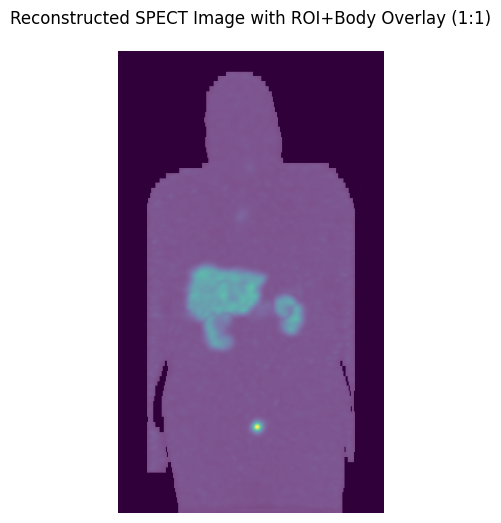

New ROI+Body seg shape: (446, 256, 256) | spacing (cm): (0.25, 0.25, 0.25)
New voxel volume: 0.015625 ml


In [ ]:
def center_origin(img):
        size = np.array(img.GetSize(), dtype=float)   # (x,y,z)
        sp = np.array(img.GetSpacing(), dtype=float)  # (x,y,z)
        origin = -0.5 * (size - 1.0) * sp
        img.SetOrigin(tuple(origin.tolist()))
        img.SetDirection((1,0,0, 0,1,0, 0,0,1))
        return img


def resample_labels_to_recon_space(label_arr_zyx, spacing_zyx_cm, recon_ref_img):
        # label_arr is (z,y,x). SITK expects array in (z,y,x) for GetImageFromArray.
        seg_img = sitk.GetImageFromArray(label_arr_zyx.astype(np.int16))
        seg_img.SetSpacing(tuple(spacing_zyx_cm[::-1]))  # (x,y,z)
        seg_img.SetDirection((1,0,0, 0,1,0, 0,0,1))
        seg_img = center_origin(seg_img)

        recon_ref_img = center_origin(recon_ref_img)

        seg_in_recon = sitk.Resample(
            seg_img,
            recon_ref_img,                 # target grid
            sitk.Transform(),              # identity
            sitk.sitkNearestNeighbor,      # MUST for labels
            0,                             # background outside
            sitk.sitkInt16
        )
        seg_arr_recon_zyx = sitk.GetArrayFromImage(seg_in_recon).astype(np.int16)
        return seg_in_recon, seg_arr_recon_zyx, seg_in_recon.GetSpacing()

seg_img_recon, seg_arr_recon, seg_spacing_recon = resample_labels_to_recon_space(roi_body_seg_arr_old, arr_px_spacing_cm_old,recon_ref)
# Example plot to show now is 1:1
plt.figure(figsize=(8, 6))
plt.imshow(np.max(recon_arr[::-1], axis=1), cmap='viridis')
plt.imshow(np.max(seg_arr_recon[::-1], axis=1), alpha=0.3, cmap='gray')
plt.title('Reconstructed SPECT Image with ROI+Body Overlay (1:1)', pad=20)
plt.axis('off')
plt.show()

# Print new spacing and voxel volume
shape_new = seg_arr_recon.shape
arr_px_spacing_cm_new = tuple(float(x) for x in seg_spacing_recon)
print(f"New ROI+Body seg shape: {shape_new} | spacing (cm): {arr_px_spacing_cm_new}")
new_vox_vol = arr_px_spacing_cm_new[0] * arr_px_spacing_cm_new[1] * arr_px_spacing_cm_new[2] # cm^3 = ml
print(f"New voxel volume: {new_vox_vol} ml")




### Build masks based off new seg roi + body

Class segmentation map: {'liver': 5, 'prostate': 22, 'kidney': 100, 'body': 200}
--- ROI: liver ---


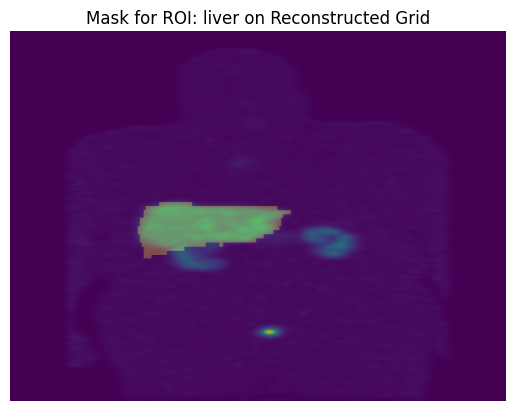

--- ROI: prostate ---


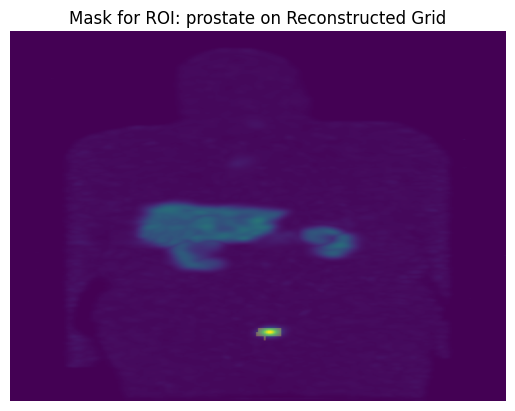

--- ROI: body ---


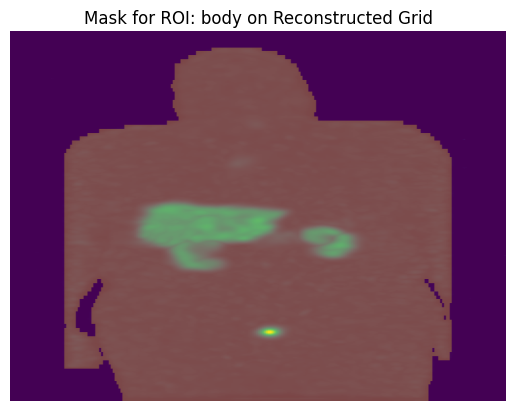

--- ROI: kidney ---


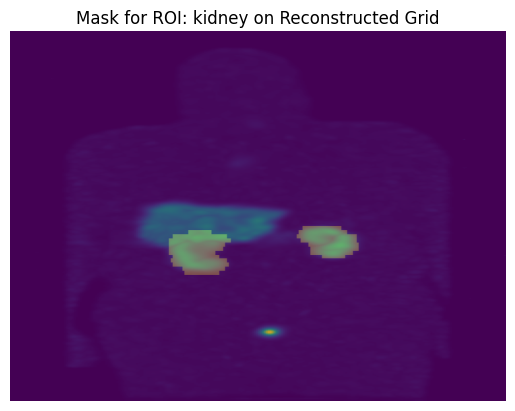

In [ ]:
def build_masks_from_labels(label_arr_zyx, class_seg):
        # class_seg: {roi_name: label_value}
        return {roi: (label_arr_zyx == int(lab)) for roi, lab in class_seg.items()}
    
class_seg = class_map.copy()
print("Class segmentation map:", class_seg)

masks_recon = build_masks_from_labels(seg_arr_recon, class_seg)

# Plot masks on recon grid
for roi in roi_list:
        print(f"--- ROI: {roi} ---")
        mask = masks_recon.get(roi)
        plt.imshow(np.max(recon_arr[::-1], axis=1), cmap='viridis')
        plt.imshow(np.max(mask[::-1], axis=1), cmap="viridis", aspect='auto',alpha=0.3)
        plt.title(f"Mask for ROI: {roi} on Reconstructed Grid")
        plt.axis("off")
        plt.show()


### Calculate total activity within each ROI and Plot with TAC of PBPK

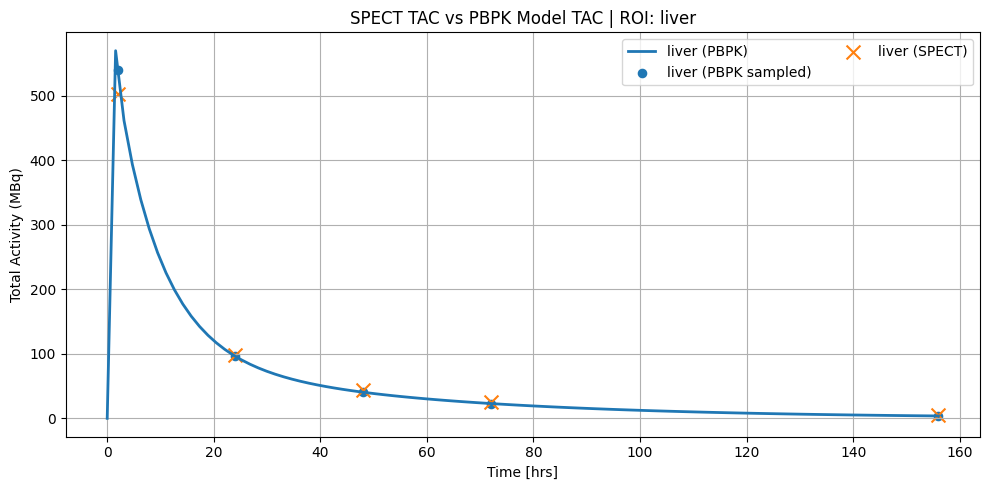

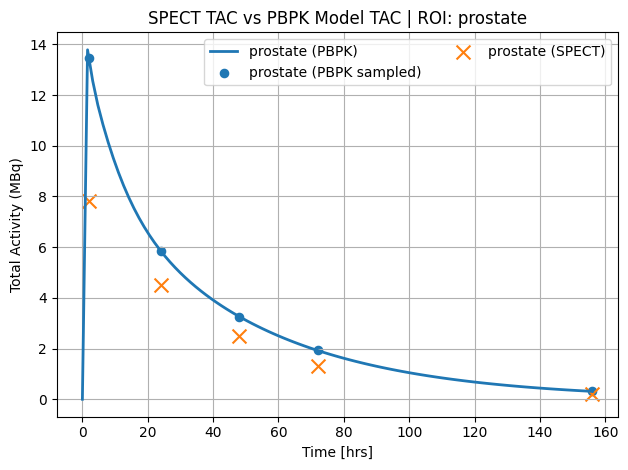

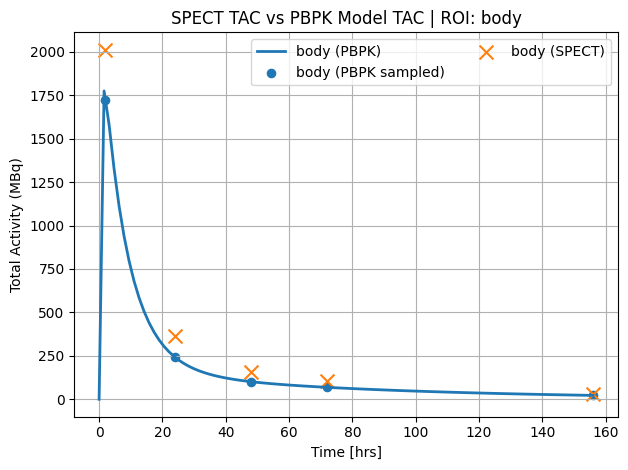

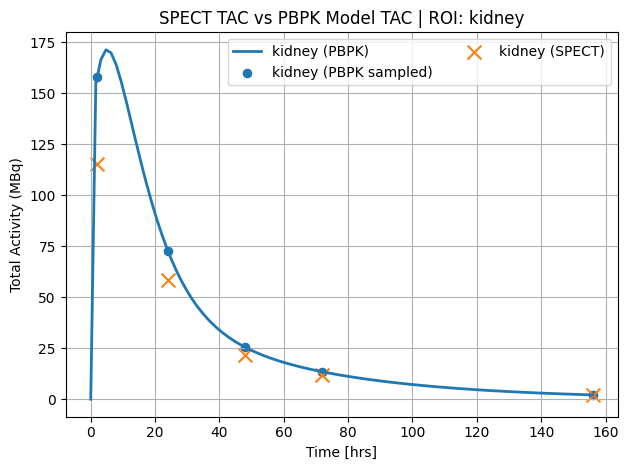

In [ ]:
def roi_stats_from_frame(recon_arr_zyx, mask_zyx, recon_vox_vol):
        nvox = int(mask_zyx.sum())
        if nvox == 0:
            return np.nan, np.nan, 0

        # Sum of activity concentration over ROI voxels (MBq/mL * voxels)
        sum_conc = float(np.sum(recon_arr_zyx, where=mask_zyx)) # MBq/mL * voxels
        mean_conc = sum_conc / nvox               # MBq/mL
        total_mbq = sum_conc * recon_vox_vol       # MBq
        return mean_conc, total_mbq, nvox

def compute_spect_tac(recon_paths, masks_recon_space, recon_vox_vol):
        n_frames = len(recon_paths)

        # Pre-allocate outputs (cleaner than append+convert)
        spect_tac = {
            roi: {
                "mean_mbq_per_ml": np.full(n_frames, np.nan, dtype=np.float32),
                "sum_mbq": np.full(n_frames, np.nan, dtype=np.float32),
                "nvox": np.zeros(n_frames, dtype=np.int32),
            }
            for roi in masks_recon_space
        }

        for i, recon_path in enumerate(recon_paths):
            recon_arr = sitk.GetArrayFromImage(sitk.ReadImage(recon_path)).astype(np.float32)  # (z,y,x)

            for roi, mask in masks_recon_space.items():
                mean_c, total_mbq, nvox = roi_stats_from_frame(recon_arr, mask, recon_vox_vol)
                spect_tac[roi]["mean_mbq_per_ml"][i] = mean_c
                spect_tac[roi]["sum_mbq"][i] = total_mbq
                spect_tac[roi]["nvox"][i] = nvox

        return spect_tac
    
spect_tac = compute_spect_tac(recon_paths, masks_recon, recon_vox_vol)
    
# plot SPECT TAC vs PBPK expected
plt.figure(figsize=(10, 5))
for roi in rois:
    roi = roi.lower()
    t_file = os.path.join(pbpk_dir_path, f"{pbpk_prefix}_{roi}_TAC_time.bin")
    t, act, t_s, act_s = load_tac_bins(roi)
    spect_sum_vals = spect_tac[roi]["sum_mbq"]
        
    # plots
    plt.plot(t/60, act, linewidth=2, label=f"{roi} (PBPK)")
    plt.scatter(t_s/60, act_s, s=35, label=f"{roi} (PBPK sampled)")
    plt.scatter([f/60 for f in frames_start_times], spect_sum_vals, s=100, marker='x', label=f"{roi} (SPECT)")
    
    plt.title(f"SPECT TAC vs PBPK Model TAC | ROI: {roi}")
    plt.xlabel("Time [hrs]")
    plt.ylabel("Total Activity (MBq)")
    plt.grid()
    plt.legend(ncol=2)  # makes legend less tall if many ROIs
    plt.tight_layout()
    plt.show()

# Report - NEED TO WORK ON

In [ ]:
# ------- COMPARE SPECT TAC VS PBPK TAC -------

# Compute SPECT TAC once
spect_tac = compute_spect_tac(recon_paths, masks_recon, recon_vox_vol)

frames_start_times = np.asarray(frames_start_times, dtype=float)  # minutes
t_hr = frames_start_times / 60.0
n_frames = len(frames_start_times)

eps = 1e-12  # for safe percent error when PBPK ~ 0

for roi in rois:
    roi_key = roi.lower()
    if roi_key not in spect_tac:
        print(f"\n[WARN] ROI '{roi_key}' not found in spect_tac keys. Skipping.")
        continue

    # ---- PBPK sampled at frame times (preferred) ----
    t, act, t_s, act_s = load_tac_bins(roi_key, base_path=pbpk_dir_path, pbpk_prefix=pbpk_prefix)
    pbpk_at_frames = np.asarray(act_s, dtype=float)

    # ---- SPECT series ----
    spect_sum_mbq = np.asarray(spect_tac[roi_key]["sum_mbq"], dtype=float)
    spect_mean_mbq_ml = np.asarray(spect_tac[roi_key]["mean_mbq_per_ml"], dtype=float)
    nvox = np.asarray(spect_tac[roi_key]["nvox"], dtype=int)

    # ---- Differences ----
    diff_mbq = spect_sum_mbq - pbpk_at_frames

    # percent error = 100 * (SPECT - PBPK) / PBPK, but nan when PBPK ~ 0
    pct_err = np.full(diff_mbq.shape, np.nan, dtype=float)
    valid = np.abs(pbpk_at_frames) > eps
    pct_err[valid] = 100.0 * diff_mbq[valid] / pbpk_at_frames[valid]

    # ============================
    # Per-ROI table
    # ============================
    print("\n" + "=" * 90)
    print(f"ROI: {roi_key}")
    print("=" * 90)

    hdr = (
        f"{'Frame':>5} | {'t(hr)':>6} | {'SPECT(MBq)':>12} | {'PBPK(MBq)':>11} | "
        f"{'Diff(MBq)':>11} | {'%Err':>8} | {'Mean(MBq/mL)':>12} | {'nvox':>7}"
    )
    print(hdr)
    print("-" * len(hdr))

    for i in range(n_frames):
        print(
            f"{i:5d} | {t_hr[i]:6.2f} | {spect_sum_mbq[i]:12.4f} | {pbpk_at_frames[i]:11.4f} | "
            f"{diff_mbq[i]:11.4f} | {pct_err[i]:8.2f} | {spect_mean_mbq_ml[i]:12.4f} | {nvox[i]:7d}"
        )



ROI: liver
Frame |  t(hr) |   SPECT(MBq) |   PBPK(MBq) |   Diff(MBq) |     %Err | Mean(MBq/mL) |    nvox
---------------------------------------------------------------------------------------------
    0 |   2.00 |     501.7471 |    540.2498 |    -38.5027 |    -7.13 |       0.2728 |  117698
    1 |  24.00 |      97.7235 |     96.3433 |      1.3802 |     1.43 |       0.0531 |  117698
    2 |  48.00 |      44.1945 |     40.4943 |      3.7002 |     9.14 |       0.0240 |  117698
    3 |  72.00 |      25.4870 |     22.9182 |      2.5688 |    11.21 |       0.0139 |  117698
    4 | 156.00 |       4.4744 |      3.6800 |      0.7943 |    21.58 |       0.0024 |  117698

ROI: prostate
Frame |  t(hr) |   SPECT(MBq) |   PBPK(MBq) |   Diff(MBq) |     %Err | Mean(MBq/mL) |    nvox
---------------------------------------------------------------------------------------------
    0 |   2.00 |       7.8388 |     13.4582 |     -5.6194 |   -41.75 |       0.3889 |    1290
    1 |  24.00 |       4.5115 |  